# Ensemble: sisnthick

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'SImon'
experiment = 'ssp585'
variable_id = 'sisnthick'

spatial_text = 'sea-ice snow layer thickness'
spatial_units = 'm'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Thickness ({time_series_units})'
time_series_y_range = (0, 0.2)
time_series_y_range_full = (0, 0.4)
time_series_y_range_monthly = (0, 0.4)
time_series_y_range_regional = (0, 0.5)
time_series_process = lambda x: x

colormesh_kwargs = {
    'extend': 'max',
    'levels': 21,
    #'shading': 'auto', # NB change to 'gouraud' if Jaspy
    'vmin': 0,
    'vmax': 0.4,
    'x': 'longitude', 
    'y': 'latitude'
}

colormesh_kwargs_sep = {
    'extend': 'max',
    'levels': 21,
    #'shading': 'auto', # NB change to 'gouraud' if Jaspy
    'vmin': 0,
    'vmax': 0.1,
    'x': 'longitude', 
    'y': 'latitude'
}

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id
)

ensemble_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)

time_slices = libs.vars.default_time_slices()
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

ensemble_collapse = [item['label'] for item in ensemble if item['si_collapse']]
ensemble_remain = [item['label'] for item in ensemble if not item['si_collapse']]

## Time series

### Mean

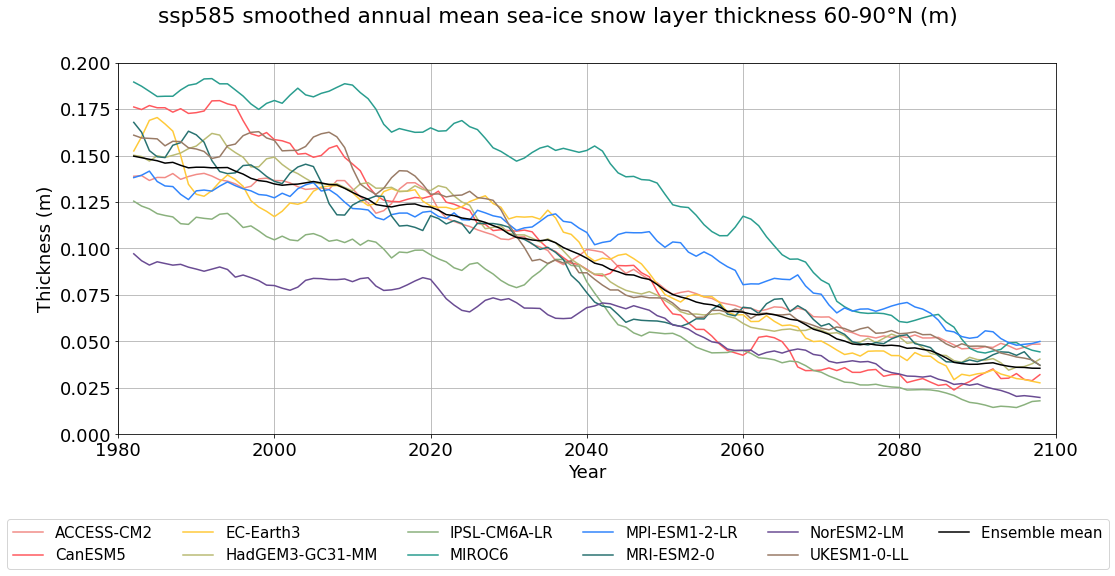

In [4]:
# libs.plot.time_series_from_vars(
#     ensemble_time_series_smooth,
#     title=f'{experiment} smoothed monthly {time_series_text} 60-90°N ({time_series_units})',
#     xattr='time',
#     ylabel=time_series_y_label,
#     yrange=time_series_y_range
# );

vars_series = [
    ensemble_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)


libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed annual mean {time_series_text} 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

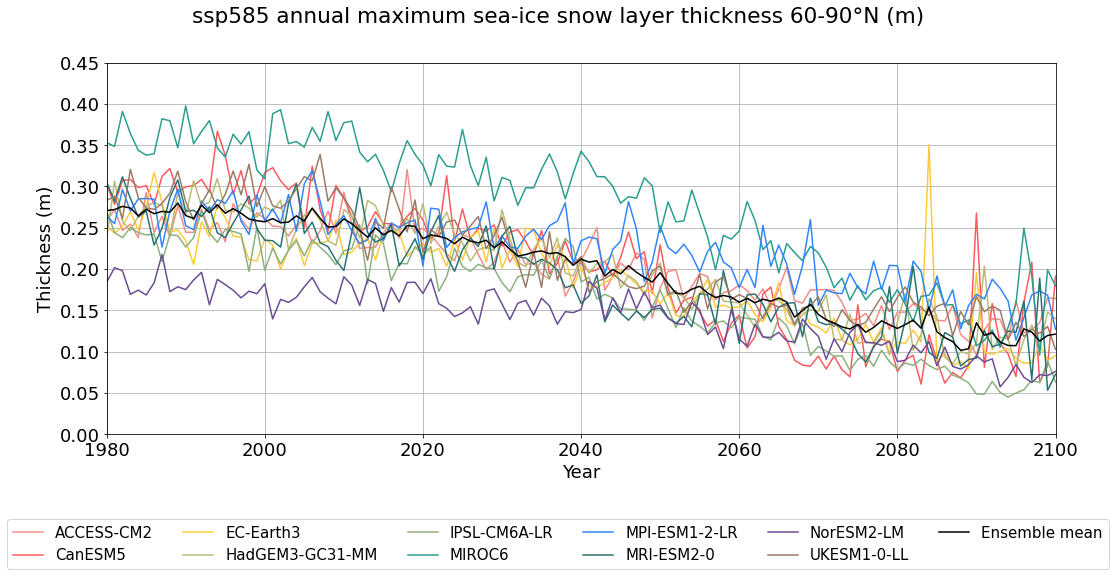

In [5]:
data_vars_max = {}

ensemble_siconc, weight_siconc = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    'siconc'
)

for i, item in enumerate(ensemble):
    processed_data = time_series_process(item['data'])
    #processed_data = processed_data.where(ensemble_siconc[i]['data'])
    processed_data.attrs['color'] = item['color']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    
    # Reduce data, i.e. taking sum or average over spatial dimensions
    item_weighted = processed_data.weighted(weight)
    item_reduced = getattr(
        item_weighted, 
        time_series_weighted_method
    )(dim=item_weighted.weights.dims, skipna=True).groupby('time.year')
    
    data_vars_max[item['label']] = item_reduced.max('time')

ds_max = xarray.Dataset(data_vars=data_vars_max)
ds_max = libs.ensemble.calc_variable_mean(ds_max)

libs.plot.time_series_from_vars(
    [ ds_max ],
    #cols=6,
    title=f'{experiment} annual maximum {time_series_text} 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=(0, 0.45)
);

In [6]:
for obj in [{ 'ds': ds_max, 'key': 'Snow depth' }]:
    print('-----', obj['key'], '-----')
    ds = obj['ds']
    libs.analysis.calc_diffs(ds, unit='m', relative=True)    

----- Snow depth -----
ACCESS-CM2
-> 1980-2010: 0.26m
-> 2080-2100: 0.14m
-> delta: -45.91%
CanESM5
-> 1980-2010: 0.30m
-> 2080-2100: 0.11m
-> delta: -63.38%
EC-Earth3
-> 1980-2010: 0.24m
-> 2080-2100: 0.11m
-> delta: -52.83%
HadGEM3-GC31-MM
-> 1980-2010: 0.27m
-> 2080-2100: 0.12m
-> delta: -54.07%
IPSL-CM6A-LR
-> 1980-2010: 0.23m
-> 2080-2100: 0.07m
-> delta: -70.88%
MIROC6
-> 1980-2010: 0.36m
-> 2080-2100: 0.15m
-> delta: -57.29%
MPI-ESM1-2-LR
-> 1980-2010: 0.27m
-> 2080-2100: 0.17m
-> delta: -39.08%
MRI-ESM2-0
-> 1980-2010: 0.26m
-> 2080-2100: 0.11m
-> delta: -56.03%
NorESM2-LM
-> 1980-2010: 0.18m
-> 2080-2100: 0.08m
-> delta: -52.45%
UKESM1-0-LL
-> 1980-2010: 0.29m
-> 2080-2100: 0.14m
-> delta: -51.12%
Ensemble mean
-> 1980-2010: 0.27m
-> 2080-2100: 0.12m
-> delta: -54.36%

Range -70.88012417068765 - -39.07663083120455
Median -54.978377500946095
Mean -54.3042117320968



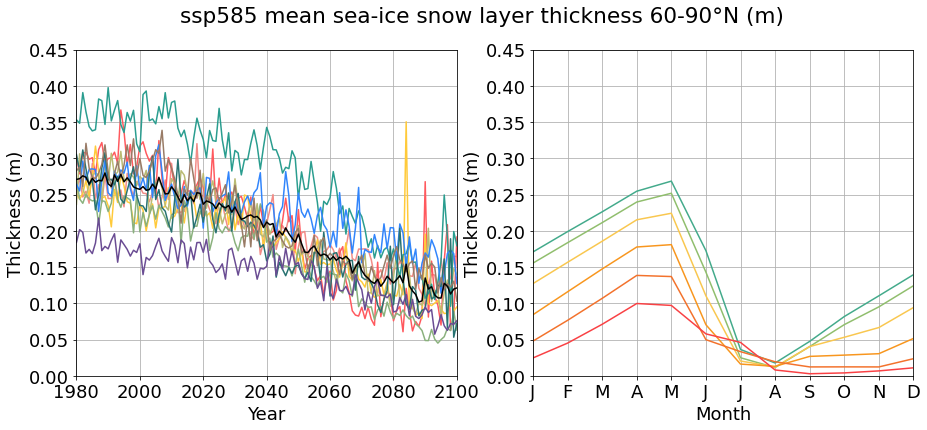

In [7]:
import matplotlib.pyplot as plt

# libs.plot.time_series_from_vars(
#     ensemble_time_series_smooth,
#     title=f'{experiment} smoothed monthly {time_series_text} 60-90°N ({time_series_units})',
#     xattr='time',
#     ylabel=time_series_y_label,
#     yrange=time_series_y_range
# );

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
fig.suptitle(f'{experiment} mean {time_series_text} 60-90°N ({time_series_units})')

vars_series = [
    ensemble_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time') #.rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)

libs.plot.time_series_from_vars(
    [
        ds_max,
    ],
    ax=axes[0],
    fig=fig,
    show_legend=False,
    xattr='year',
    ylabel=time_series_y_label,
    yrange=(0, 0.45)
);

arr = []
for s in libs.vars.time_slices_20y():
    s_label = s['label']
    data_slice = ensemble_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    data_slice['Ensemble mean'].attrs['color'] = s['color']
    data_slice['Ensemble mean'].attrs['label'] = s['label']
    arr.append(data_slice)

libs.plot.monthly_variability(
    arr,
    ax=axes[1],
    fig=fig,
    legend_below=True,
    show_legend=False,
    variables=['Ensemble mean'],
    ylabel=time_series_y_label,
    yrange=(0, 0.45)
);

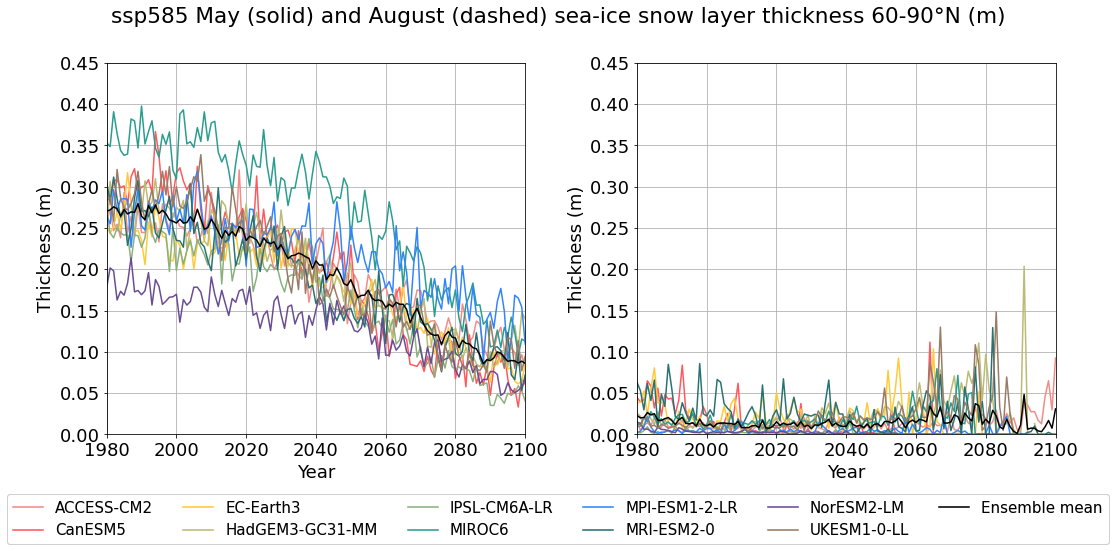

In [8]:
data_vars_max = {}
data_vars_min = {}

for i, item in enumerate(ensemble):
    processed_data = time_series_process(item['data'])
    #processed_data = processed_data.where(ensemble_siconc[i]['data'])
    processed_data.attrs['color'] = item['color']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    
    # Reduce data, i.e. taking sum or average over spatial dimensions
    item_weighted_may = processed_data.where(processed_data.time['time.month'] == 5, drop=True).weighted(weight)
    item_reduced_may = getattr(
        item_weighted_may, 
        time_series_weighted_method
    )(dim=item_weighted_may.weights.dims, skipna=True).groupby('time.year')
    
    item_weighted_aug = processed_data.where(processed_data.time['time.month'] == 8, drop=True).weighted(weight)
    item_reduced_aug = getattr(
        item_weighted_aug, 
        time_series_weighted_method
    )(dim=item_weighted_aug.weights.dims, skipna=True).groupby('time.year')
    
    data_vars_max[item['label']] = item_reduced_may.mean('time')
    data_vars_min[item['label']] = item_reduced_aug.mean('time')

ds_max = xarray.Dataset(data_vars=data_vars_max)
ds_max = libs.ensemble.calc_variable_mean(ds_max)

ds_min = xarray.Dataset(data_vars=data_vars_min)
ds_min = libs.ensemble.calc_variable_mean(ds_min)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle(f'{experiment} May (solid) and August (dashed) {time_series_text} 60-90°N ({time_series_units})')

libs.plot.time_series_from_vars(
    [
        ds_max
    ],
    #cols=6,
    ax=axes[0],
    fig=fig,
    xattr='year',
    ylabel=time_series_y_label,
    yrange=(0, 0.45)
);
libs.plot.time_series_from_vars(
    [
        ds_min
    ],
    #cols=6,
    ax=axes[1],
    fig=fig,
    xattr='year',
    ylabel=time_series_y_label,
    yrange=(0, 0.45)
);

### Full variability

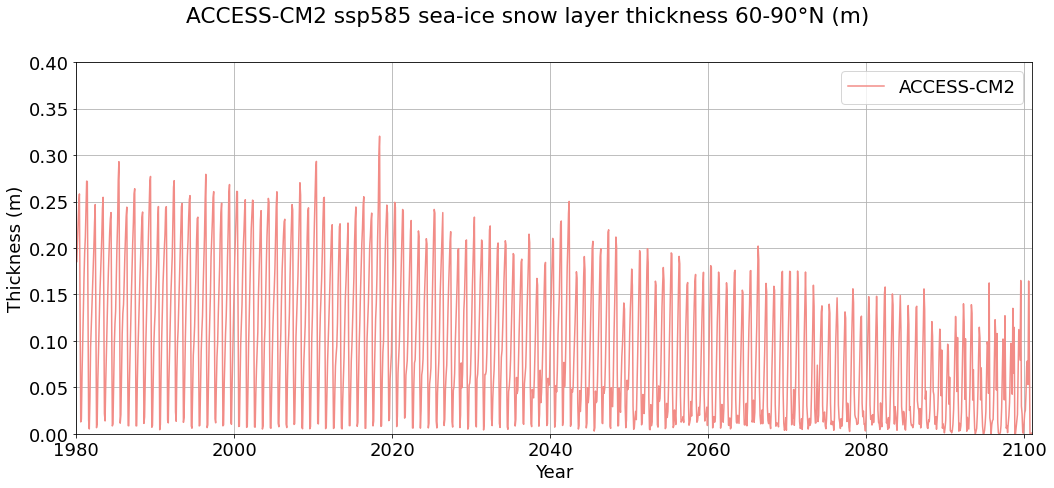

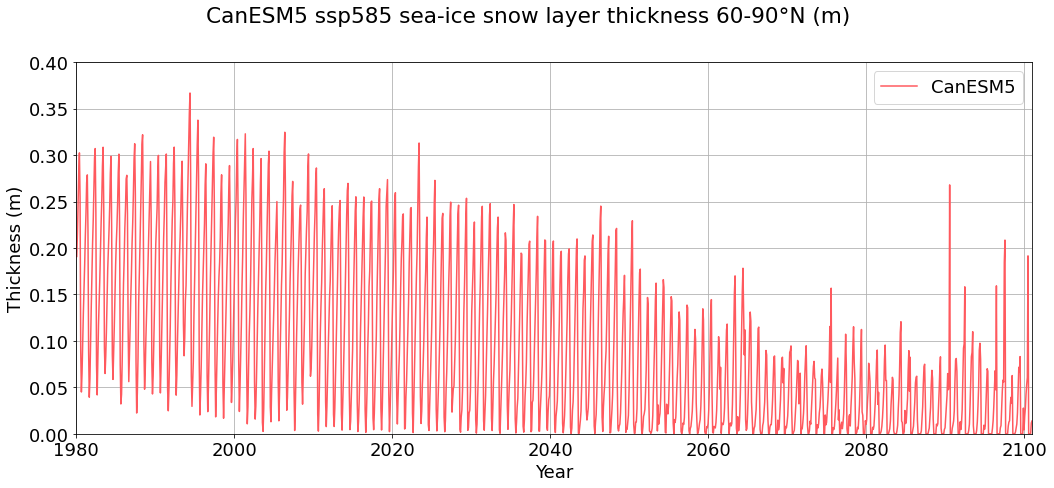

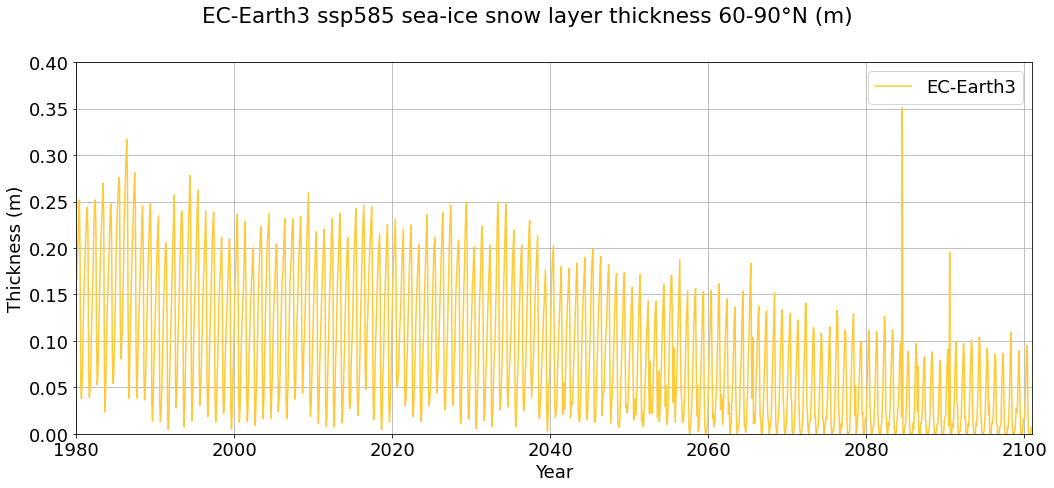

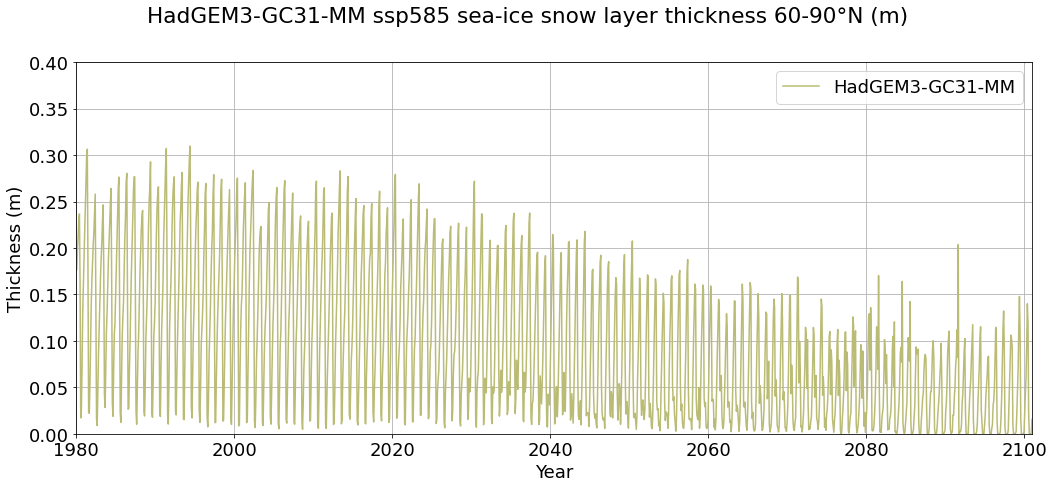

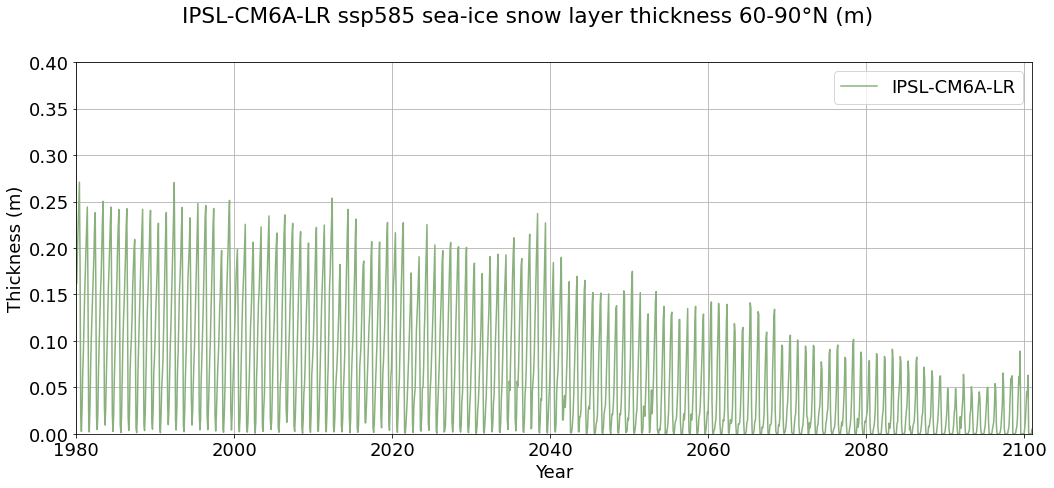

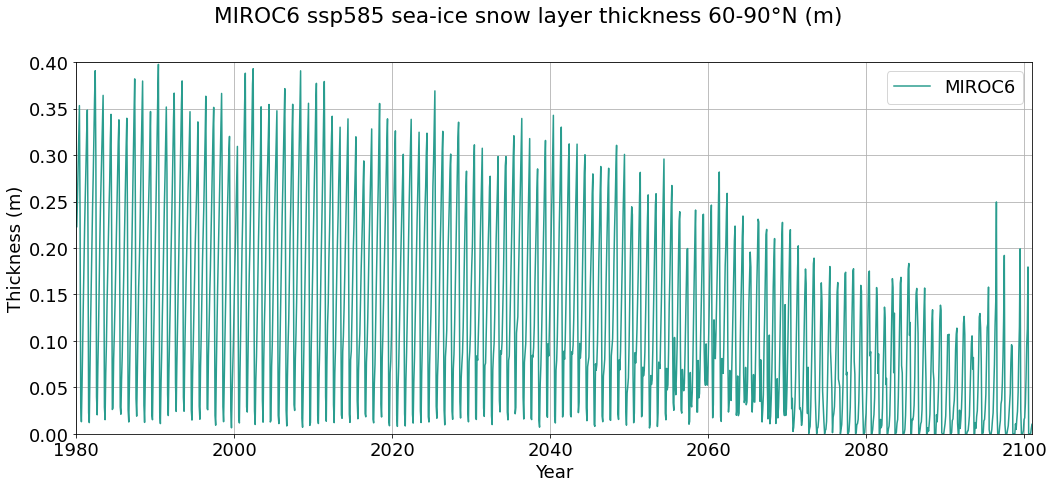

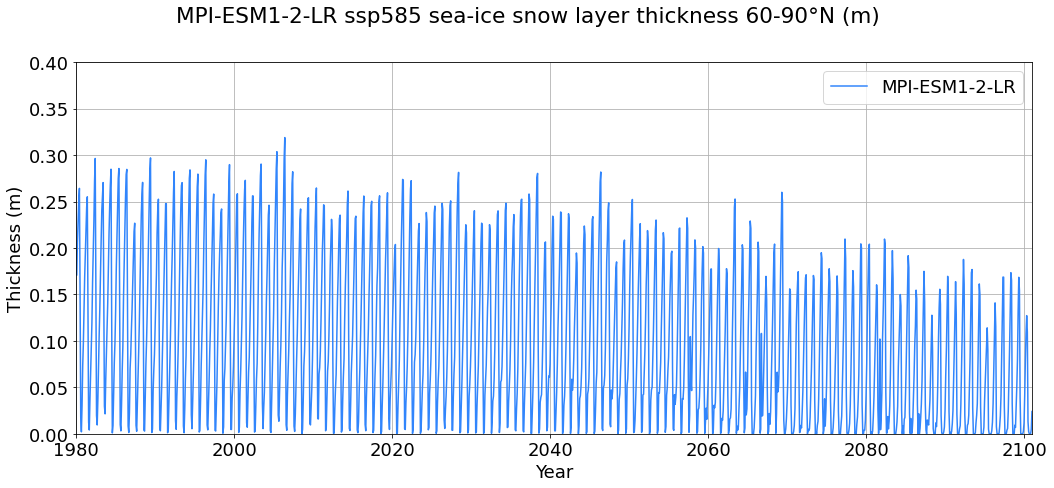

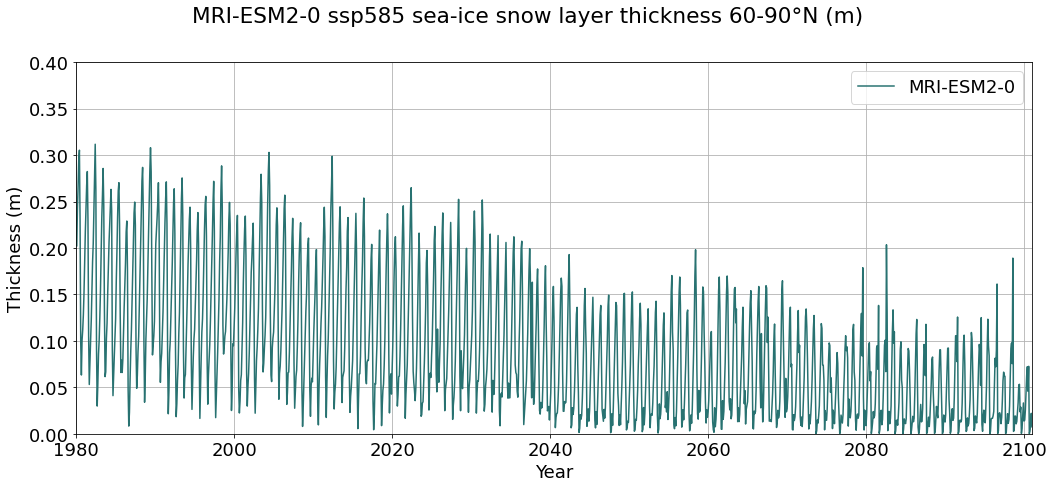

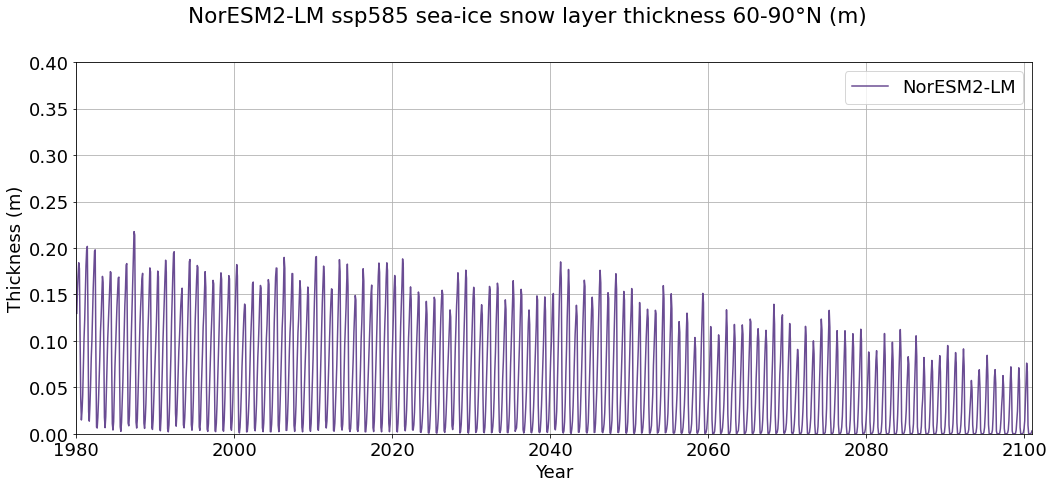

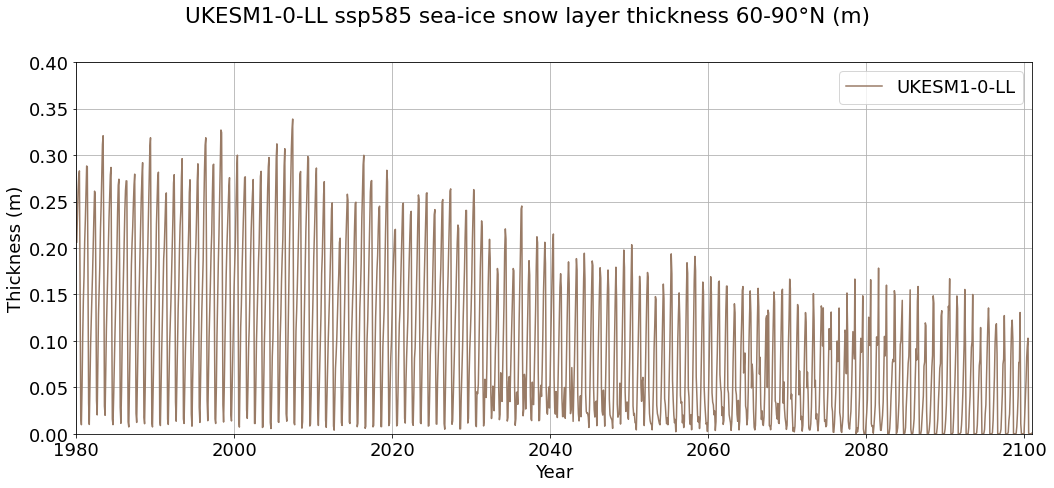

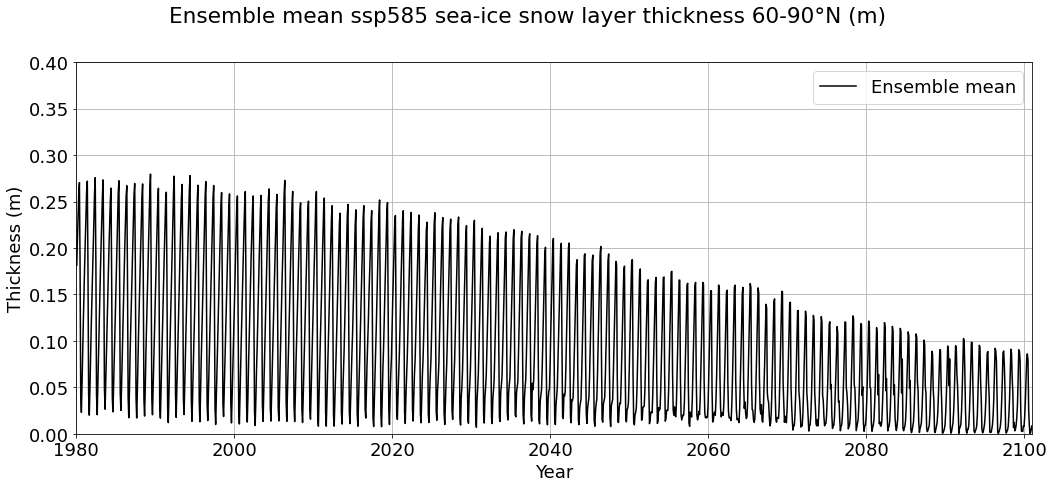

In [9]:
libs.ensemble.time_series_full_variability(
    ensemble_time_series,
    plot_kwargs={
        'title': f'{{member}} {experiment} {time_series_text} 60-90°N ({time_series_units})',
        'ylabel': time_series_y_label,
        'yrange': time_series_y_range_full
    }
)

## Monthly variability

### Full region (time)

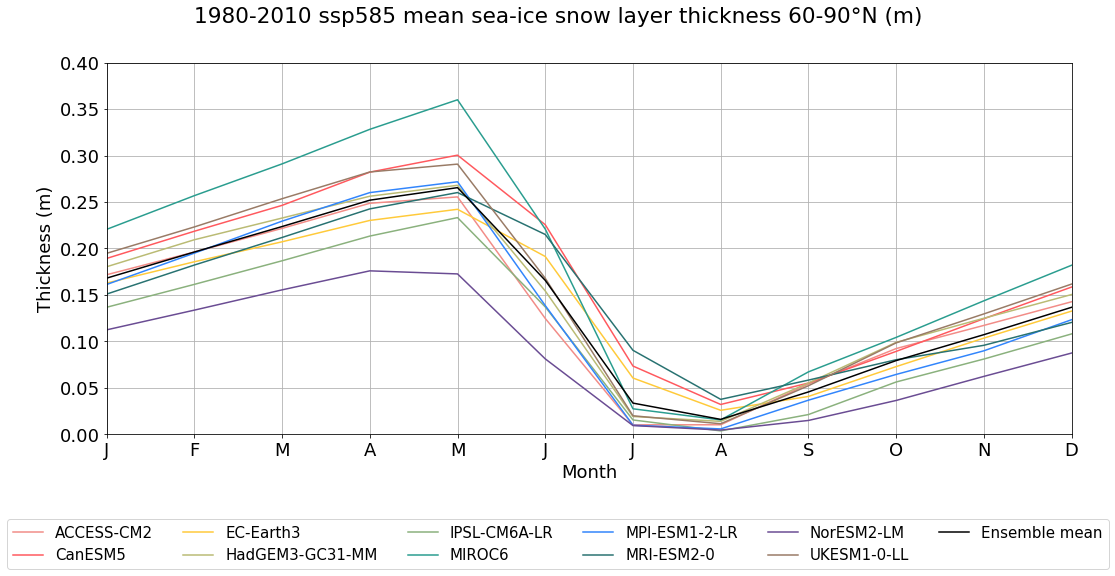

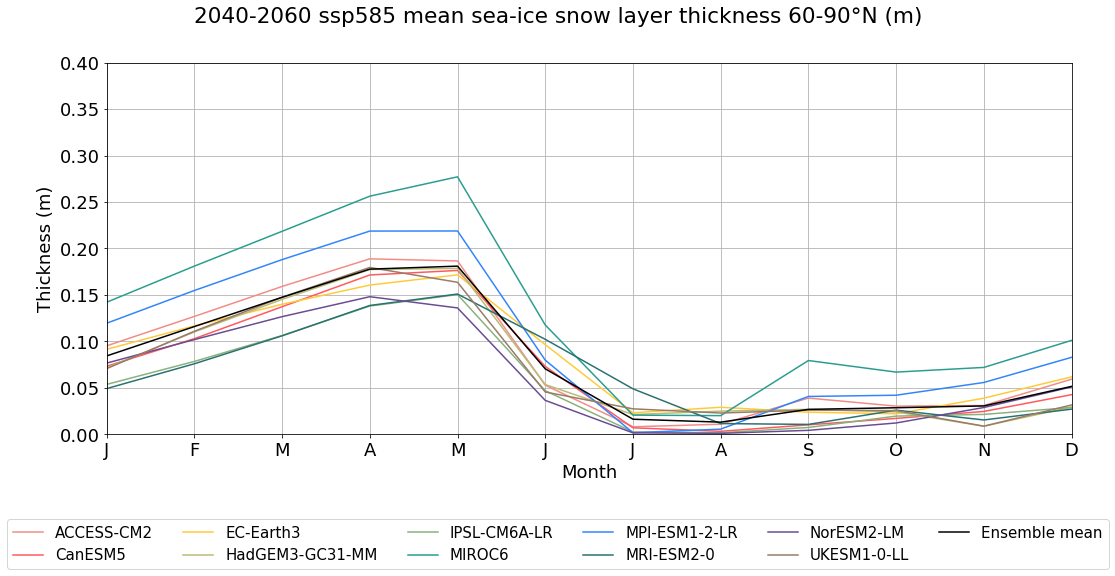

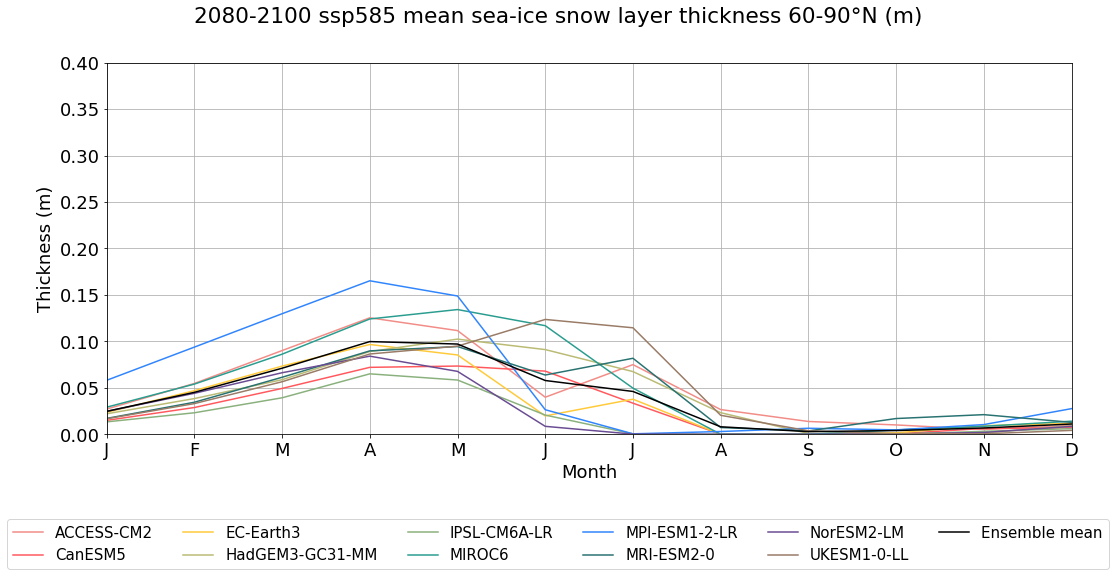

In [10]:
for s in time_slices:
    s_label = s['label']

    libs.plot.monthly_variability(
        ensemble_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    )

### Regional (time)

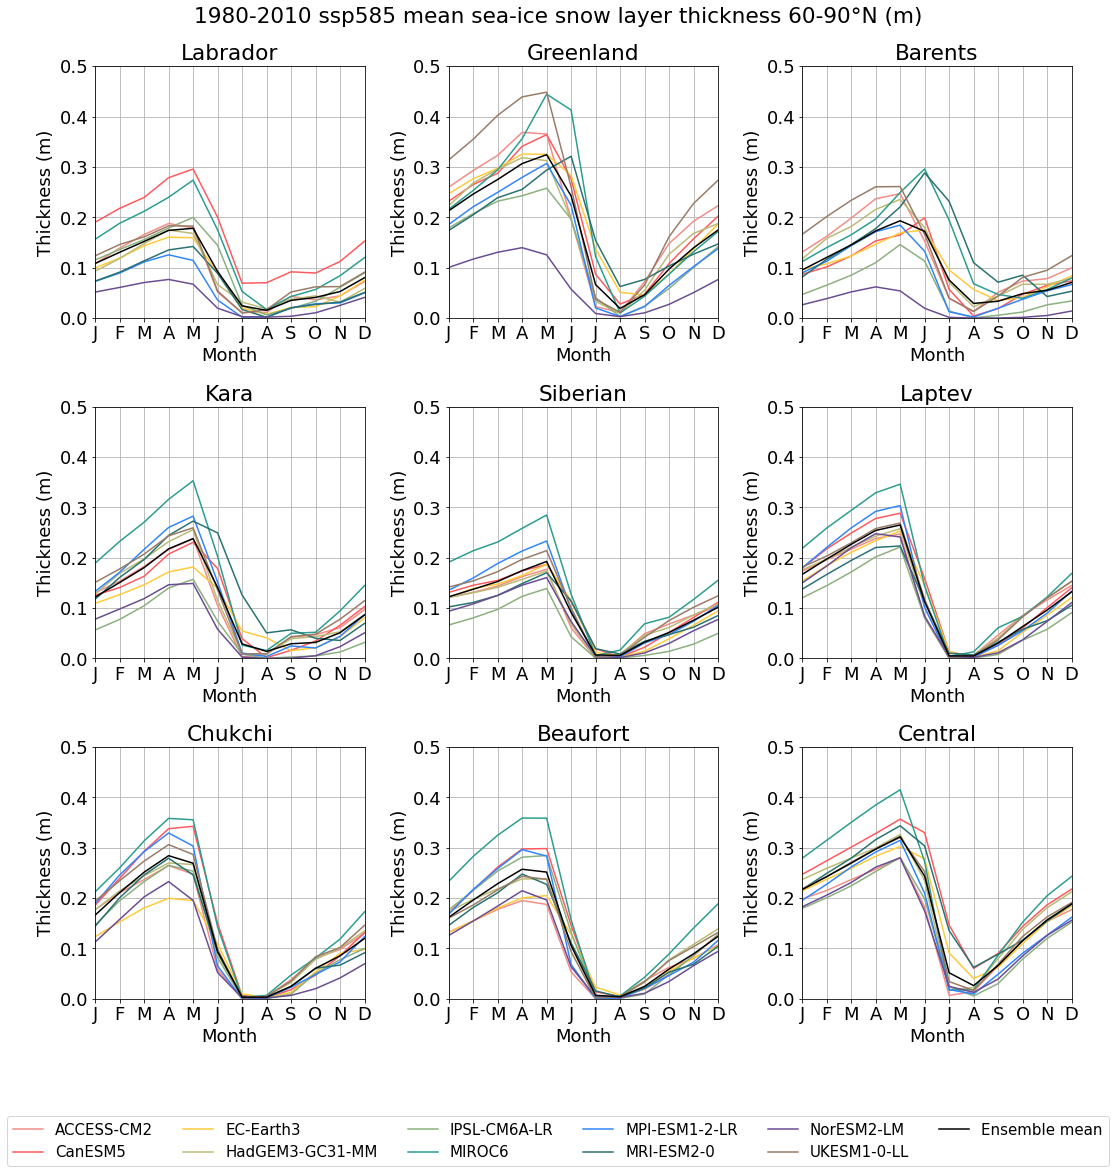

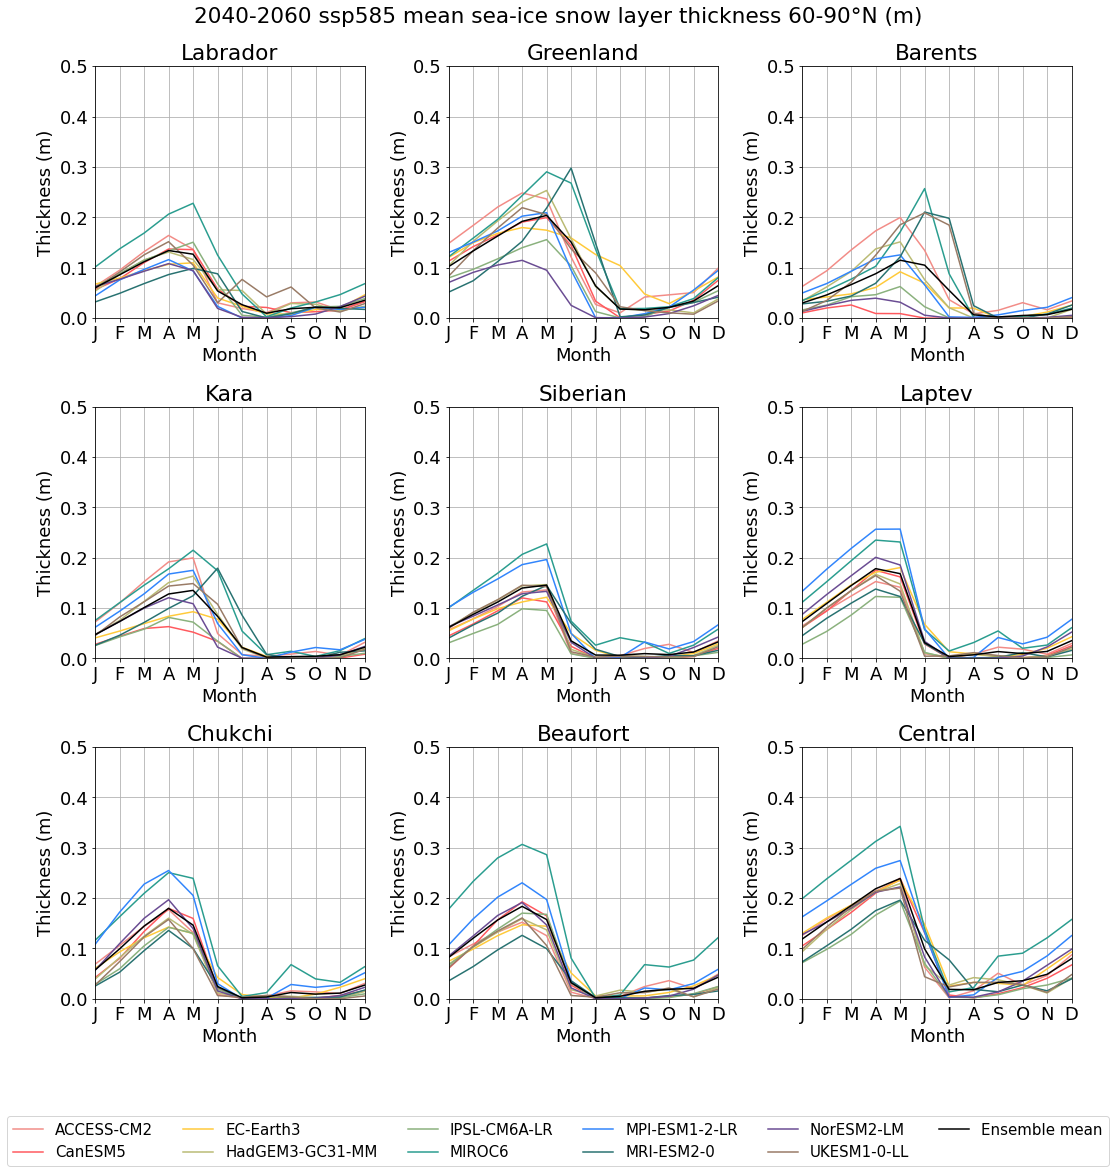

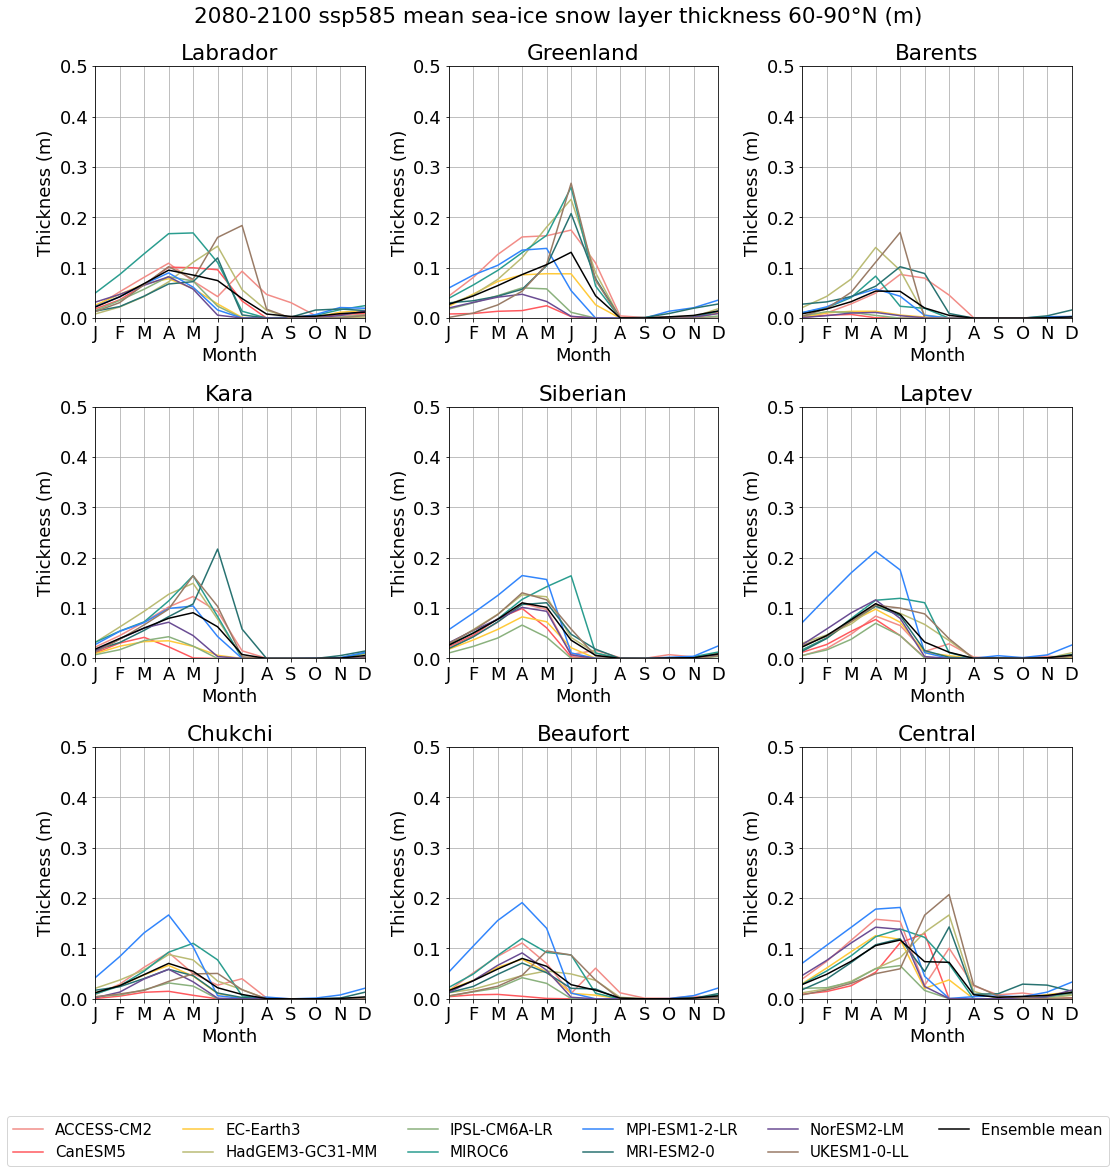

In [11]:
regions = libs.local.get_ensemble_regional_series(variable_id, experiment)

for s in time_slices:
    s_label = s['label']
    regional_time_slices = [
        time_series_process(
            data.sel(**s['slice'])
        ).groupby('time.month').mean('time') for data in regions
    ]

    libs.plot.monthly_variability_regional(
        regional_time_slices,
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_regional
    )

### Full region May (spatial)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='MAY',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)

### Full region August (spatial)

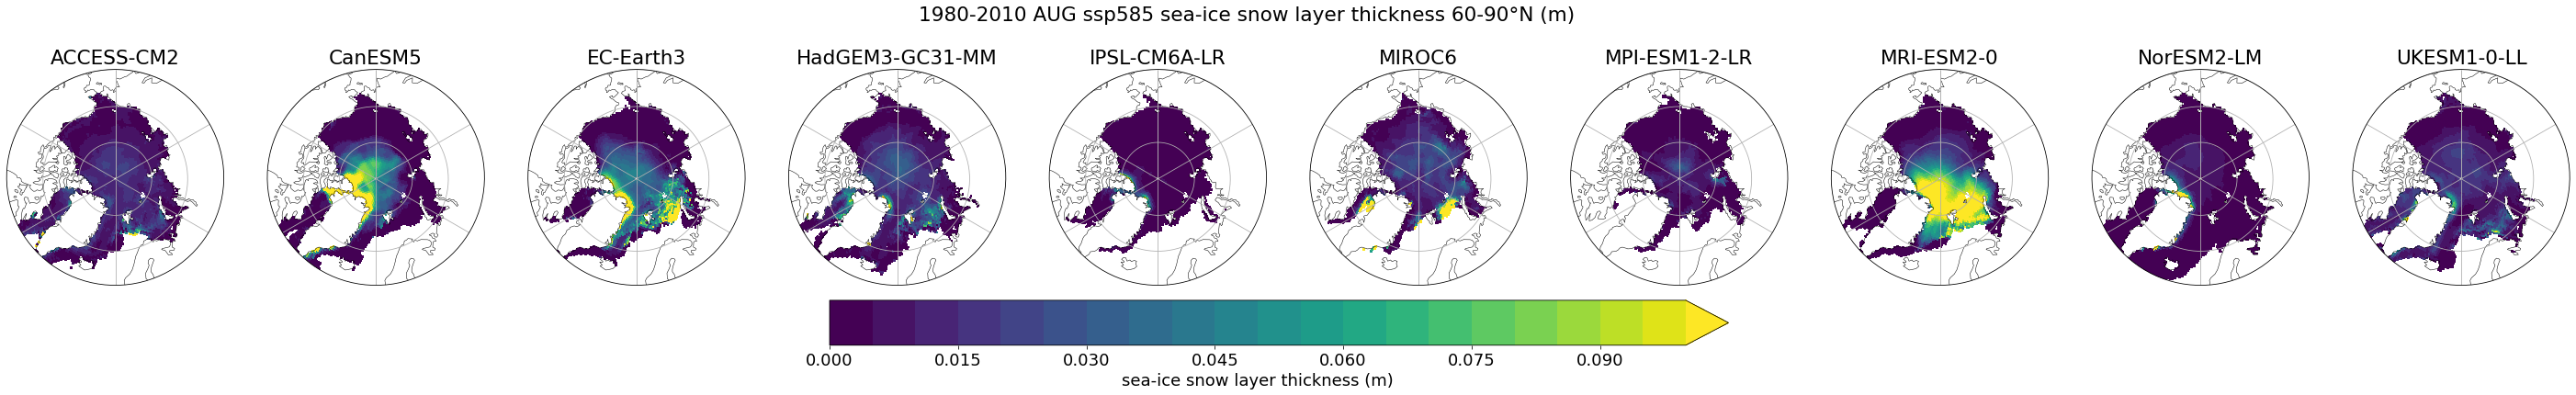

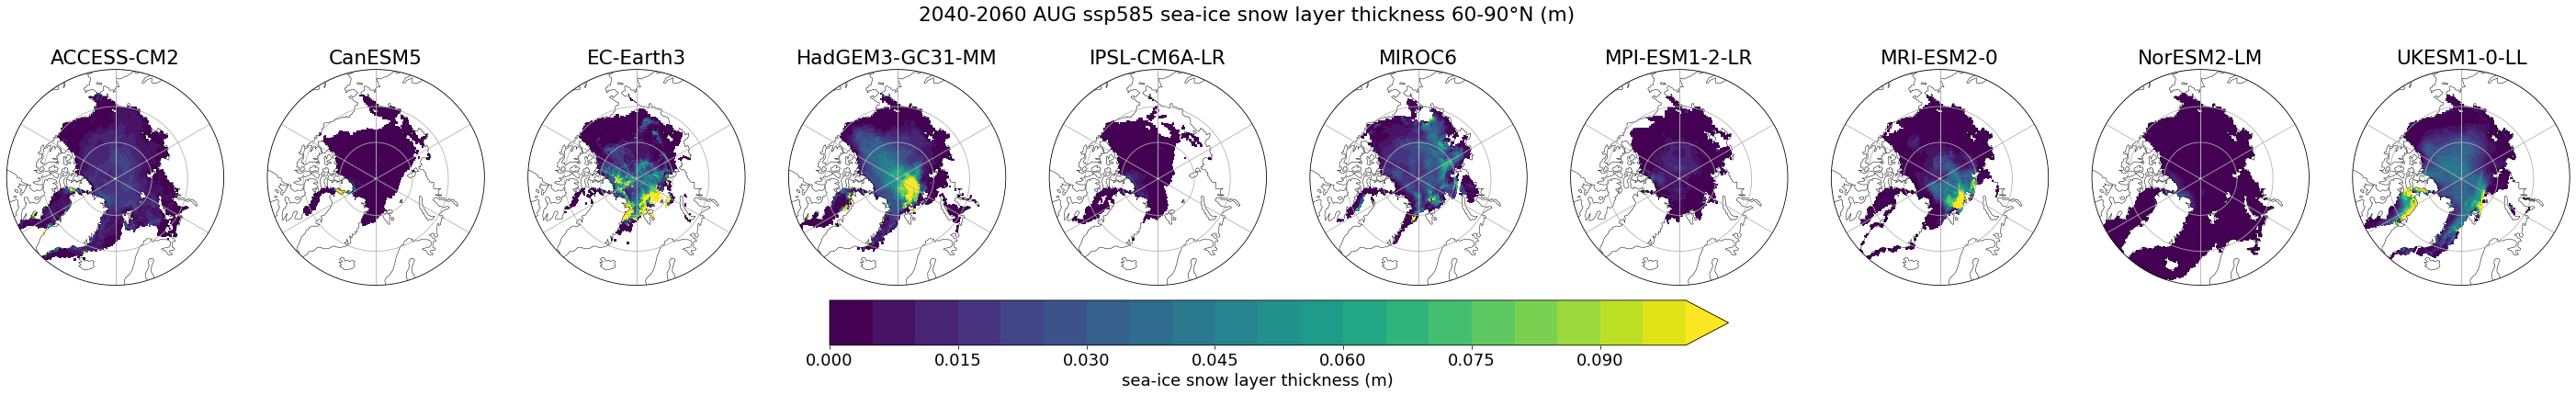

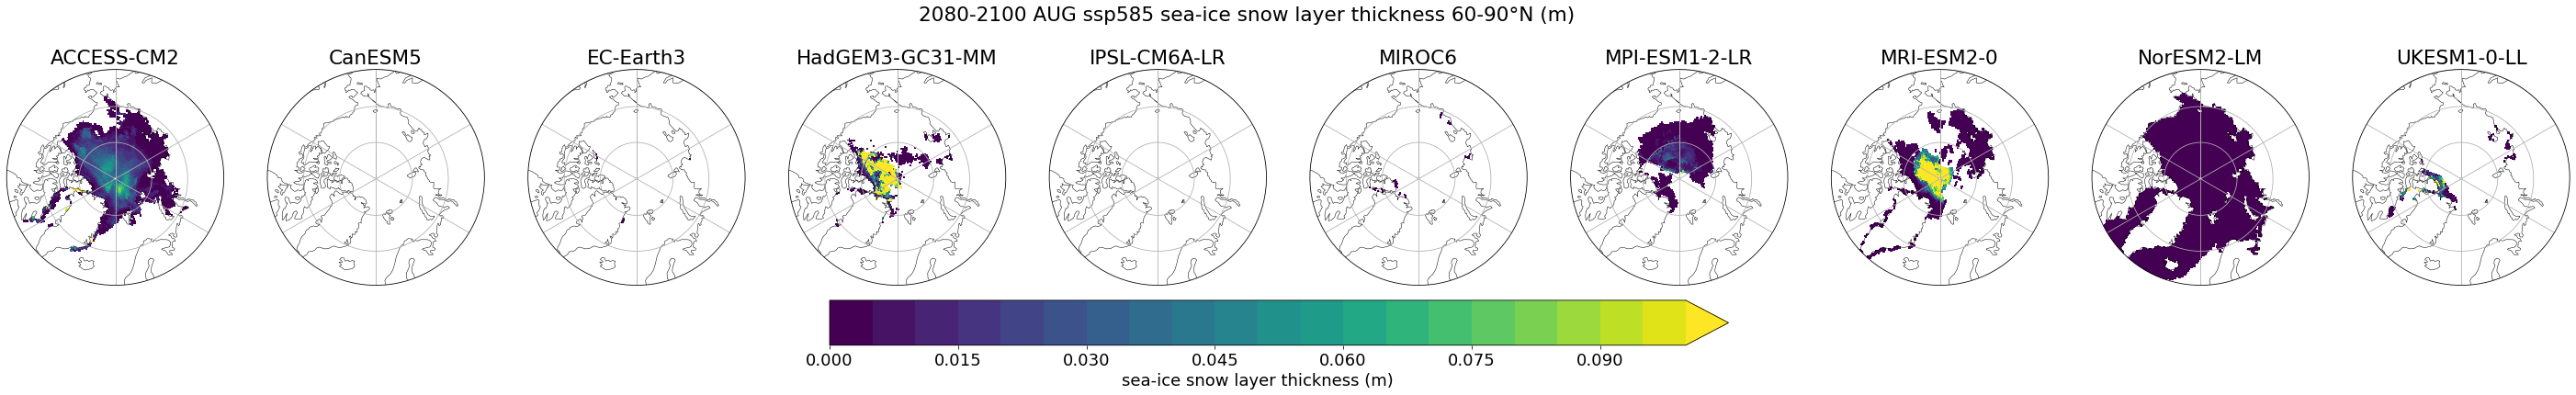

In [13]:
libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs_sep,
    text=spatial_text,
    time='AUG',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)